## Stack heatmap & Generate a centroid

In [ ]:
import os
import numpy as np
import cv2
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm 

# Setup
sample_name = "1002_left"
pred_fovea_dir = f"{sample_name}/predictions/fovea/"
scorecam_mask_dir = f"ScoreCam/{sample_name}/masked_images/"
scorecam_centroid_dir = f"ScoreCam/{sample_name}/centroid/"

os.makedirs(scorecam_mask_dir, exist_ok=True)
os.makedirs(scorecam_centroid_dir, exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and move to device
model.to(device)
model.eval()

# Preprocessing (same as training)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
    #                      [0.229, 0.224, 0.225])  # ImageNet std
])

# Initialize ScoreCAM
scorecam = ScoreCAM(model, target_layer=target_layer)

# Get all class 1 image filenames
img_filenames = sorted([
    f for f in os.listdir(pred_fovea_dir)
    if f.endswith((".png", ".jpg", ".jpeg"))
])

masked_stack = []

# Process images with progress bar
for img_name in tqdm(img_filenames, desc="Processing ScoreCAM"):
    img_path = os.path.join(pred_fovea_dir, img_name)
    original_img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(original_img).unsqueeze(0).to(device)

    # Get CAM
    with torch.no_grad():
        cam = scorecam(input_tensor)[0] 
        cam_np = cam.squeeze().cpu().numpy()  # Shape: (H, W)
        cam = cv2.resize(cam_np, original_img.size)

    # Binary mask
    mask = (cam > 0.5).astype(np.uint8)
    masked_stack.append(mask)

    # Blend CAM heatmap with original image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    original_np = np.array(original_img)
    blended = cv2.addWeighted(original_np, 0.5, heatmap, 0.5, 0)

    # Save blended image
    cv2.imwrite(os.path.join(scorecam_mask_dir, img_name), blended)

# Calculate overlap mask and centroid
stack_array = np.stack(masked_stack, axis=0)
overlap_mask = (np.sum(stack_array, axis=0) > (len(masked_stack) // 2)).astype(np.uint8)

moments = cv2.moments(overlap_mask)
if moments["m00"] != 0:
    cx = int(moments["m10"] / moments["m00"])
    cy = int(moments["m01"] / moments["m00"])
else:
    cx, cy = 0, 0

# Draw centroid on middle image
mid_idx = len(img_filenames) // 2
mid_img_path = os.path.join(pred_fovea_dir, img_filenames[mid_idx])
mid_img = cv2.imread(mid_img_path)

centroid_img = mid_img.copy()
cv2.circle(centroid_img, (cx, cy), radius=5, color=(0, 0, 255), thickness=-1)
print(f"📌 centroid: ({cx},{cy})")

# Save image with centroid
centroid_img_path = os.path.join(scorecam_centroid_dir, f"{img_filenames[mid_idx].split('.')[0]}_centroid.png")
cv2.imwrite(centroid_img_path, centroid_img)
print(f"✅ Centroid coordinates: {centroid_img_path}")

Processing ScoreCAM: 100%|██████████| 22/22 [19:21<00:00, 52.81s/it]

Centroid coordinates: ✅


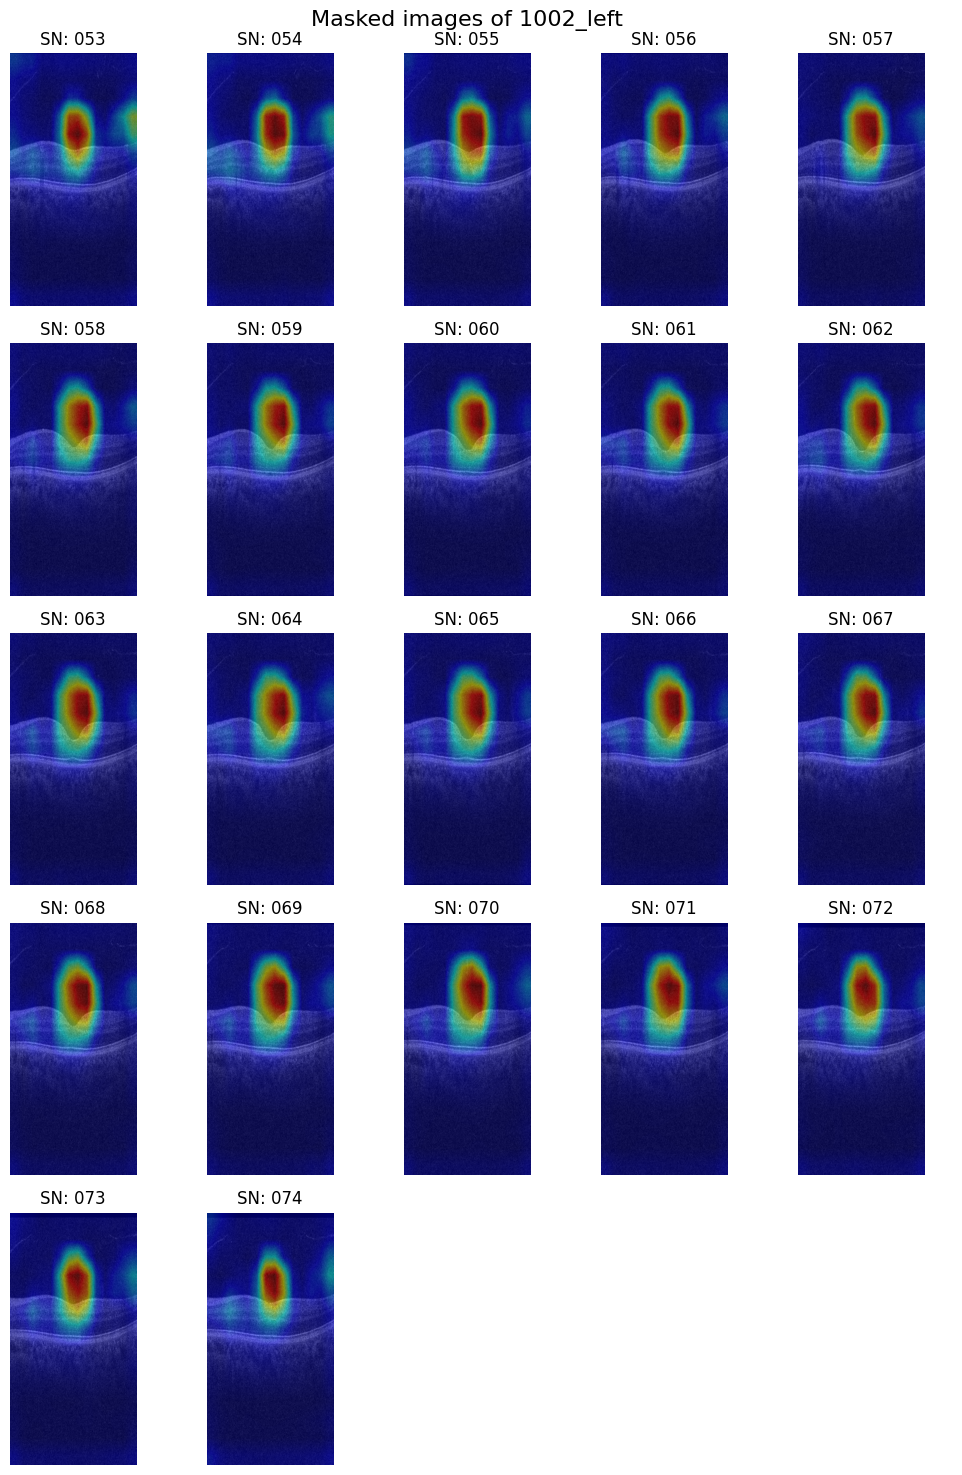

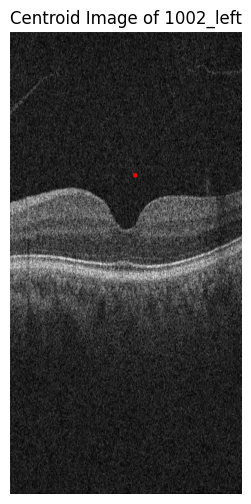

In [ ]:
def show_masked_images(volume_path):
    # Get sample name
    sample_name = os.path.basename(os.path.dirname(os.path.dirname(volume_path)))

    # Read masked images
    img_filenames = sorted([
    f for f in os.listdir(volume_path)
    if f.endswith((".png", ".jpg", ".jpeg"))
    ])  

    num_images_to_show = len(img_filenames)
    images_per_row = 5
    num_rows = math.ceil(num_images_to_show / images_per_row)

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(10, 3 * num_rows))
    axes = axes.flatten()  # Flatten to make indexing easier

    for img_name in img_filenames:
        # Extract serial number from image name
        serial_number = img_name.split("_")[-1].split(".")[0]
        idx = img_filenames.index(img_name)
        # Load image
        img = Image.open(os.path.join(volume_path, img_name))  # Load image
        axes[idx].imshow(img)
        axes[idx].axis("off")
        axes[idx].set_title(f"SN: {serial_number}")  # Display sequence number as title

    # Hide unused subplots
    for idx in range(num_images_to_show, len(axes)):
        axes[idx].axis("off")

    plt.suptitle(f"Masked images of {sample_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

def show_centriod_image(img_path):
    # Get sample name
    sample_name = os.path.basename(os.path.dirname(os.path.dirname(img_path)))
    # print(f"Sample name: {sample_name}")

    plt.figure(figsize=(6, 6))
    centriod = Image.open(img_path)
    plt.axis("off")
    plt.title(f"Centroid Image of {sample_name} at ({cx},{cy})")
    plt.imshow(centriod)   
    
volume_path = "ScoreCam/1002_left/masked_images/"
show_masked_images(volume_path)
centroid_path = "ScoreCam/1002_left/centroid/1002_left/predictions/fovea/1002_left_bscan_064_centroid.png"
show_centriod_image(centroid_path)

the middle image index: 64
centriod on the enface image: (276, 256)


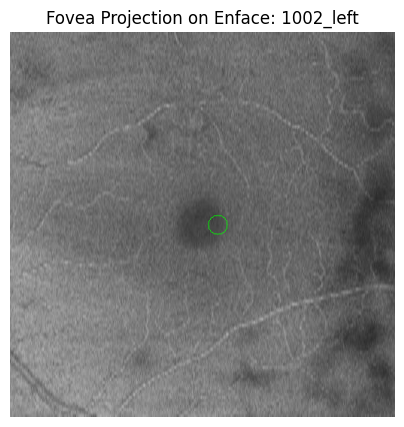

In [ ]:
def draw_fovea_enface(sample_name, cx, bscan_idx, enface_path="enface_images", output_root="ScoreCam", radius=10, color=(0, 255, 0)):
    """
    Map centroid from B-scan into enface image, draw it, visualize, and save.

    Args:
        sample_name (str): e.g. '1002_left'
        cx (int): centroid x-coordinate from B-scan (width = 1024)
        bscan_idx (int): slice index in volume (1–128)
        enface_path (str): directory containing enface images
        output_root (str): root folder for saving ScoreCam results
        radius (int): radius of the marker to draw
        color (tuple): BGR color for the marker
    """
    
    def map_centroid_to_enface(cx, bscan_idx, bscan_width=1024, num_slices=128, enface_size=512):
        x_enface = cx # correct ✅
        y_enface = int((bscan_idx / num_slices) * enface_size) # correct ✅
        return x_enface, y_enface

    def draw_centroid_on_enface(image, x, y, radius=10, color=(0, 255, 0)):
        canvas = image.copy()
        cv2.circle(canvas, (x, y), radius, color, thickness=1)
        return canvas

    # Load the enface image
    enface_img_path = os.path.join(enface_path)
    enface_img = cv2.imread(enface_img_path)

    if enface_img is None:
        raise FileNotFoundError(f"Enface image not found at {enface_img_path}")
    
    # Map centroid
    x_enface, y_enface = map_centroid_to_enface(cx, bscan_idx)

    # Draw centroid
    annotated_img = draw_centroid_on_enface(enface_img, x_enface, y_enface, radius=radius, color=color)

    # Save result
    output_dir = os.path.join(output_root, sample_name)
    os.makedirs(output_dir, exist_ok=True)
    save_path = os.path.join(output_dir, "fovea_enface.png")
    cv2.imwrite(save_path, annotated_img)
    print(f"the middle image index: {bscan_idx}")
    print(f"centriod on the enface image: ({x_enface}, {y_enface})")

    # Visualize
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Fovea Projection on Enface: {sample_name}")
    plt.axis("off")
    plt.show()

sample_name = "1002_left"
enface_path = "1002_left/1002_Enface.jpg"
centroid_path = "ScoreCam/1002_left/centroid/1002_left/predictions/fovea/1002_left_bscan_064_centroid.png"
mid_idx = int(centroid_path.split("/")[-1].split(".")[0].split("_")[-2])
draw_fovea_enface(sample_name=sample_name, cx=cx, bscan_idx=mid_idx, enface_path=enface_path, radius=13)